In [13]:
from GGMS.solvers import *
from GGMS.spd_generators import *
from GGMS.stat_funcs import *
from tqdm import tqdm
import pandas as pd

In [46]:
N = 20
n = 22
delta = 0.1

In [47]:
precision = np.diag([delta for _ in range(N-1)], 1) + np.diag([delta for _ in range(N-1)], -1) + np.eye(N)
covariance = np.linalg.inv(precision)
pc = pcorr(precision)
ed = pcorr_to_edge_dict(pc)
G = edge_dict_to_graph(ed, N)

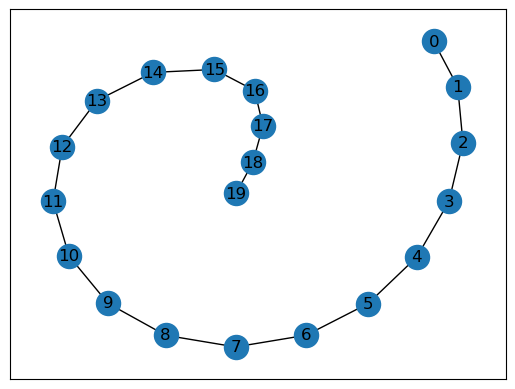

In [48]:
nx.draw_networkx(G)

In [52]:
S_obs = 3000
solvers = [SimInf(), Bonferroni(), Holm(), BenjaminiHochberg(), BenjaminiYekutieli()]

In [53]:
solver_results = {solver.__class__.__name__: [[], [], [], [], []] for solver in solvers}

for _ in tqdm(range(S_obs)):
    samples = np.random.multivariate_normal(np.zeros(N), covariance, size=n)
    X = perform_test(samples, inv=np.linalg.inv)
    for solver in solvers:
        solver.fit(X)
        sname = solver.__class__.__name__
        tp, tn, fp, fn = confusion(solver.graph, G)
        solver_results[sname][0].append(tp)
        solver_results[sname][1].append(tn)
        solver_results[sname][2].append(fp)
        solver_results[sname][3].append(fn)
        solver_results[sname][4].append(fp / (fp + tp) if fp + tp > 0 else 0)

100%|██████████| 3000/3000 [04:06<00:00, 12.15it/s]


In [54]:
solver_means = {}
for solver in solver_results:
    solver_means[solver] = np.mean(np.array(solver_results[solver]), axis=1)

solver_means = pd.DataFrame(solver_means, index=['TP', 'TN', 'FP', 'FN', 'FDR']).T
solver_means['TPR'] = solver_means['TP'] / (solver_means['TP'] + solver_means['FN'])
solver_means

,TP,TN,FP,FN,FDR,TPR
SimInf,1.859333,154.602333,16.397667,17.140667,0.688460,0.097860
Bonferroni,0.009000,170.909333,0.090667,18.991000,0.005105,0.000474
Holm,0.012000,170.877333,0.122667,18.988000,0.005104,0.000632
BenjaminiHochberg,0.356333,167.789667,3.210333,18.643667,0.029701,0.018754
BenjaminiYekutieli,0.050333,170.562000,0.438000,18.949667,0.004178,0.002649
